In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import (OrdinalEncoder,
                                    RobustScaler, 
                                    OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.sparse import csr_matrix

from funcs_ethic_ai import (clean_dataset, 
                            get_X_Y_from_df,
                            get_truth_pred_dataframe,
                            get_TPR_FPR_per_group,
                            create_cat_n_num_col_list)
from plot_funcs_ethic_ai import (plot_attribute_distribution,
                                plot_grouped_attribute_distribution,
                                plot_fairness_metrics)

/Users/tanyagolubev/Projects/ethic_ai/.ethic_ai/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


## 1. Download and clean datasets

In [2]:
#train dataset
df_raw = pd.read_csv("census+income/adult.data")
df_raw_processed = clean_dataset(df_raw)

#test_dataset
df_test_raw = pd.read_csv("census+income/adult.test", skiprows=[0], header=None)
df_test = clean_dataset(df_test_raw)

Deleted duplicated rows: 24, 0.0%
Deleted rows with empty values: 0, 0%
Number of entries in a dataset after cleaning: 30138, 7.0% from initial dataset were dismissed
Deleted duplicated rows: 5, 0.0%
Deleted rows with empty values: 0, 0%
Number of entries in a dataset after cleaning: 15055, 8.0% from initial dataset were dismissed


In [3]:
# on order to make processing of training and testing datasets consistent, 
# I delete one row containing native country not appearing in test dataset
value_to_drop = 'Holand-Netherlands'
df = df_raw_processed[df_raw_processed["native_country"] != value_to_drop]

## 2. Let's focus on sensetive attributes: race and gender

### 2.1 Dataset is skewed: not equal amounts of sensetive groups

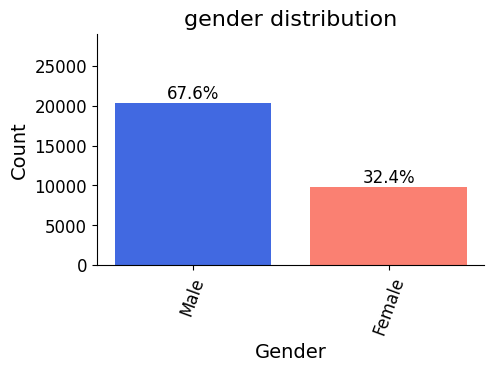

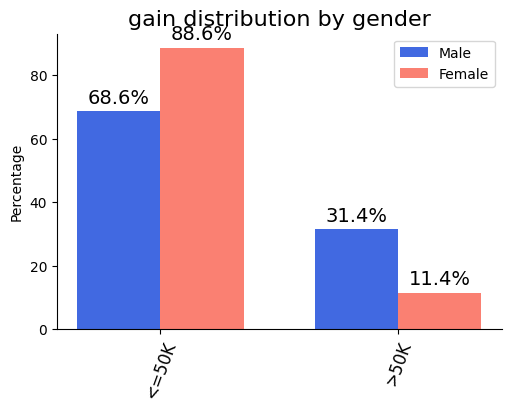

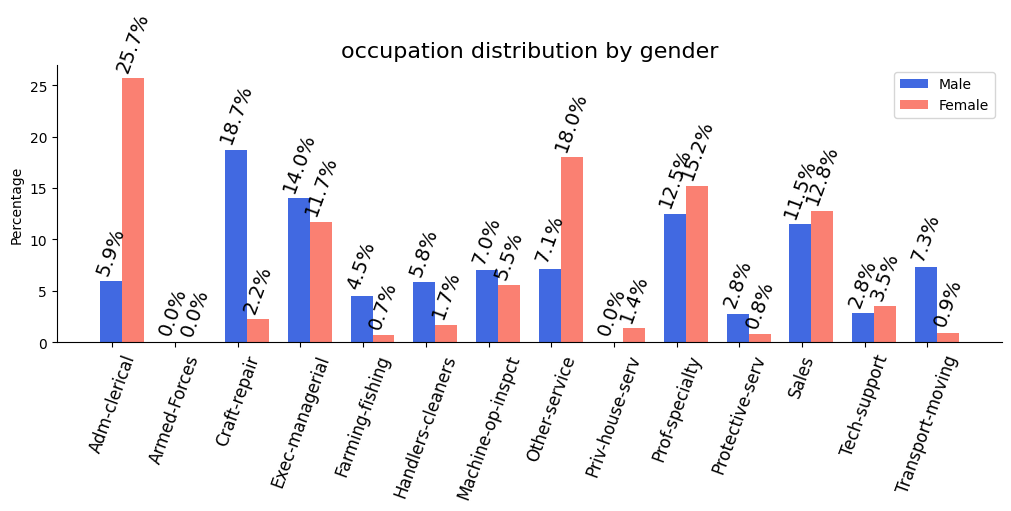

In [4]:
plot_attribute_distribution(df, "gender")
plot_grouped_attribute_distribution(df, "gender", "gain")
plot_grouped_attribute_distribution(df, "gender", "occupation", figsize=(10,5), annotaion_rotation=70)

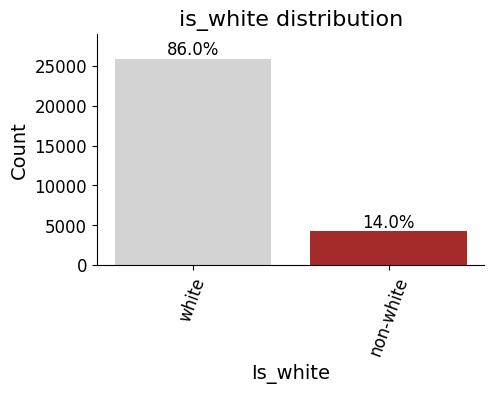

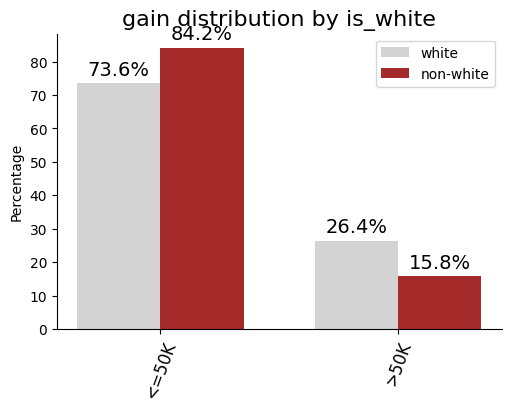

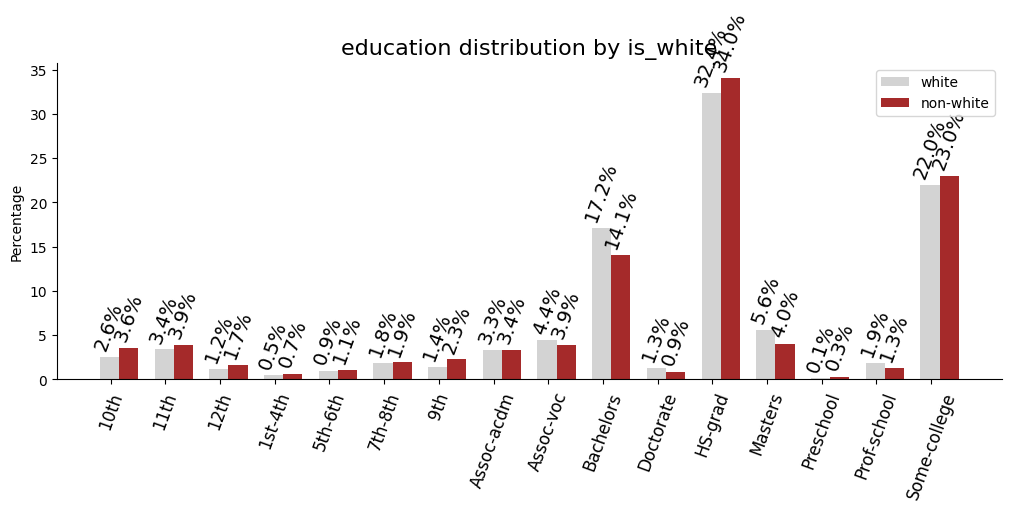

In [5]:
plot_attribute_distribution(df, "is_white")
plot_grouped_attribute_distribution(df, "is_white", "gain")
plot_grouped_attribute_distribution(df, "is_white", "education", figsize=(10,5), annotaion_rotation=70)

# 3. Evaluate Neuronal Network predictions

## 3.1. Vanila prediction - dataset taken "as it is"

In [6]:
#get the full dataframe
X_processed_vanila, y = get_X_Y_from_df(df_test)
df_truth_pred_vanila = get_truth_pred_dataframe (df, df_test)
df_X_truth_pred = pd.concat([X_processed_vanila, df_truth_pred_vanila], axis=1)

In [7]:
#calculate accuracy
vanila_accuracy = accuracy_score(df_X_truth_pred[">50K"], df_X_truth_pred[">50K_pred"])

#calculate fairness for gender attribute
female_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", False)
male_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", True)

#calculate fairness for is_white attribute
white_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", True)
not_white_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", False)

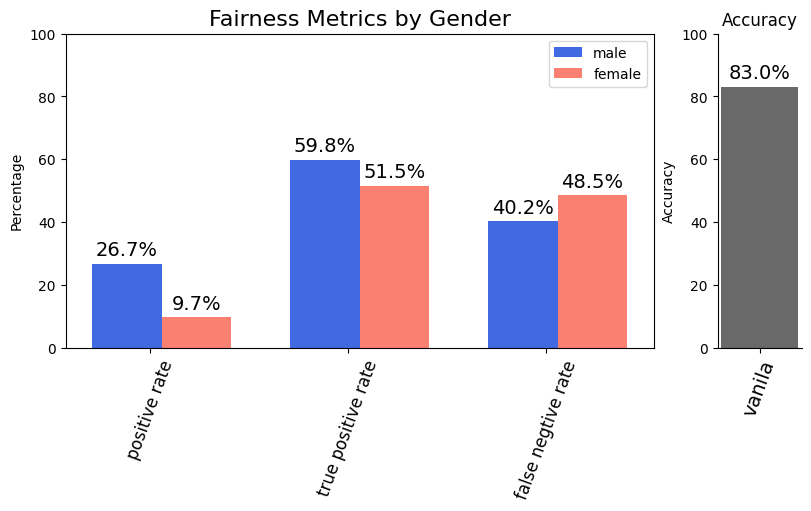

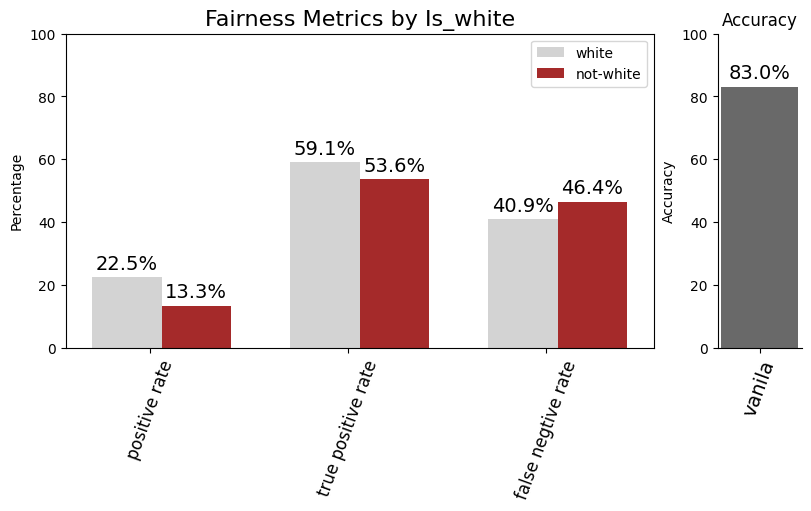

In [8]:
plot_fairness_metrics(100*vanila_accuracy, "vanila", [male_fair_metrics, female_fair_metrics], "gender")
plot_fairness_metrics(100*vanila_accuracy, "vanila", [white_fair_metrics, not_white_fair_metrics], "is_white")

## 3.2 Disregard sensetive attributes

In [9]:
df_blind = df.drop(columns=["gender", "is_white"])
df_test_blind = df_test.drop(columns=["gender", "is_white"])

#get the full dataframe
df_truth_pred_blind = get_truth_pred_dataframe (df_blind, df_test_blind)
df_X_truth_pred = pd.concat([X_processed_vanila, df_truth_pred_blind], axis=1)

In [10]:
#calculate accuracy
blind_accuracy = accuracy_score(df_X_truth_pred[">50K"], df_X_truth_pred[">50K_pred"])

#calculate fairness for gender attribute
female_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", False)
male_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", True)

#calculate fairness for is_white attribute
white_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", True)
not_white_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", False)

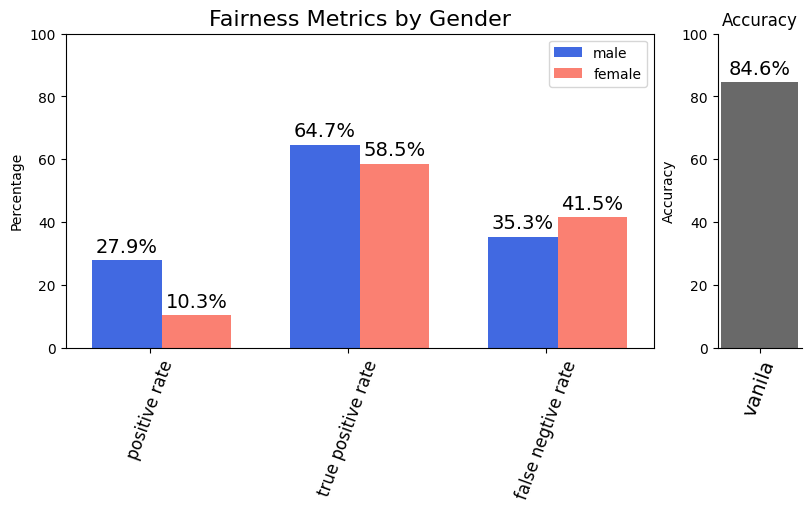

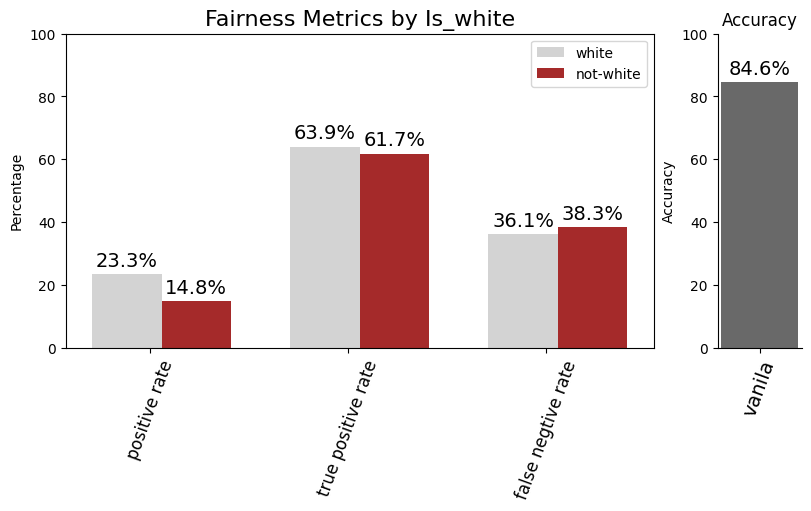

In [11]:
plot_fairness_metrics(100*blind_accuracy, "vanila", [male_fair_metrics, female_fair_metrics], "gender")
plot_fairness_metrics(100*blind_accuracy, "vanila", [white_fair_metrics, not_white_fair_metrics], "is_white")

## 3.3 Normalize dataset to contain the same amount of high earning  represeentatives

In [12]:
mew = df[(df["is_white"]=="white")&(df["gain"]==">50K")&(df["gender"]=="Male")]
non_mew = df[~((df["is_white"]=="white")&(df["gain"]==">50K")&(df["gender"]=="Male"))]

num_rows_to_select = int(0.445 * len(mew))
random_male_rows = mew.sample(n=num_rows_to_select, random_state=2)
ans = pd.concat([non_mew, random_male_rows], axis=0)

ans_pm = ans[~((ans["gender"]=="Female")&(ans["gain"]=="<=50K"))]

ans_unpw_w = ans[(ans["gender"]=="Female")&(ans["gain"]=="<=50K")&(ans["is_white"]=="white")]
ans_unpw_nw = ans[(ans["gender"]=="Female")&(ans["gain"]=="<=50K")&(ans["is_white"]=="non-white")]

num_rows_to_select = int(0.55 * len(ans_unpw_w))
random_w_rows = ans_unpw_w.sample(n=num_rows_to_select, random_state=2)
num_rows_to_select = int(0.67 * len(ans_unpw_nw))
random_nw_rows = ans_unpw_nw.sample(n=num_rows_to_select, random_state=2)

df_balanced = pd.concat([ans_pm, random_w_rows, random_nw_rows], axis=0)

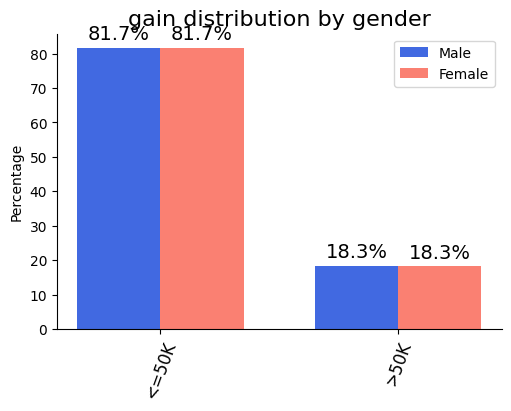

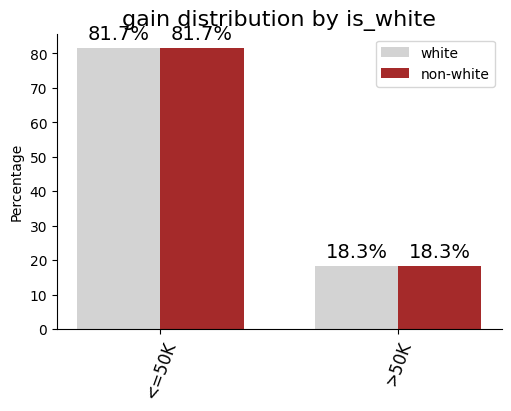

In [13]:
plot_grouped_attribute_distribution(df_balanced, "gender", "gain")
plot_grouped_attribute_distribution(df_balanced, "is_white", "gain")

In [14]:
#get the full dataframe
df_truth_pred_balance = get_truth_pred_dataframe(df_balanced, df_test)
df_X_truth_pred = pd.concat([X_processed_vanila, df_truth_pred_balance], axis=1)

In [15]:
#calculate accuracy
normalized_accuracy = accuracy_score(df_X_truth_pred[">50K"], df_X_truth_pred [">50K_pred"])

#calculate fairness for gender attribute
female_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", False)
male_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "gender_Male", True)

#calculate fairness for is_white attribute
white_fair_metrics = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", True)
not_white_fair_metrics  = get_TPR_FPR_per_group(df_X_truth_pred, "is_white_white", False)

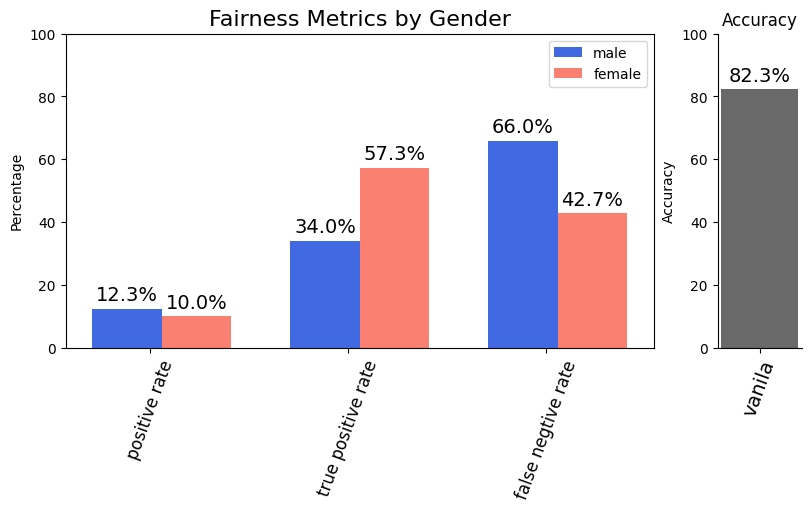

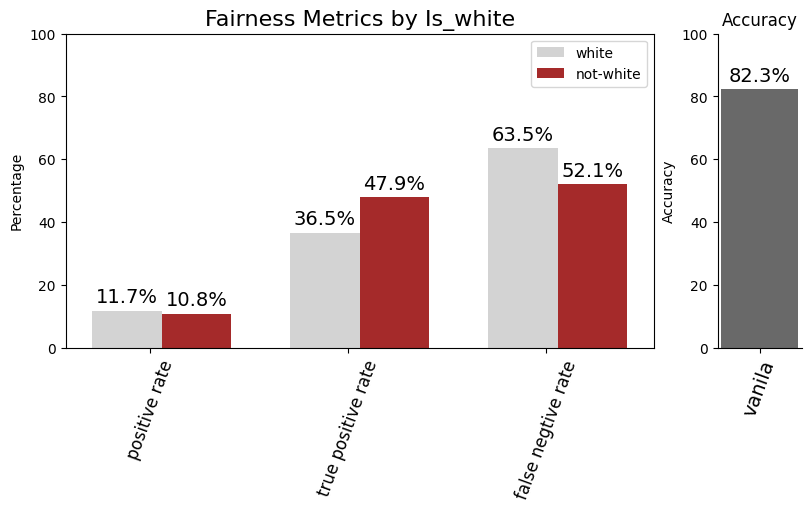

In [16]:
plot_fairness_metrics(100*normalized_accuracy, "vanila", [male_fair_metrics, female_fair_metrics], "gender")
plot_fairness_metrics(100*normalized_accuracy, "vanila", [white_fair_metrics, not_white_fair_metrics], "is_white")

## 3.4 Use odds-equalizing post-processing algorithm for bias mitigiation

In [17]:
X_train, y_train = get_X_Y_from_df(df)
X_test, y_test = get_X_Y_from_df(df_test)

#define the model
model = MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu', solver='adam', max_iter=1000, random_state=12)

#train the model
model.fit(X_train, np.ravel(y_train))

#get predictions using the previously trained model
y_train_pred_arr = model.predict(X_train)
y_train_pred = pd.Series(y_train_pred_arr, index=y_train.index, name=y_train.name)
y_test_pred_arr = model.predict(X_test)
y_test_pred = pd.Series(y_test_pred_arr, index=y_test.index, name=y_train.name)

In [18]:
protected_attribute = 'gender_Male'
label_name = '>50K'

# Create a BinaryLabelDataset object
dataset_train = BinaryLabelDataset(favorable_label=True,
                             unfavorable_label=False,
                             df=pd.concat([X_train, y_train], axis=1),
                             label_names=[label_name],
                             protected_attribute_names=[protected_attribute])

dataset_train_pred = BinaryLabelDataset(favorable_label=True,
                             unfavorable_label=False,
                             df=pd.concat([X_train, y_train_pred], axis=1),
                             label_names=[label_name],
                             protected_attribute_names=[protected_attribute])

dataset_test = BinaryLabelDataset(df=pd.concat([X_test, y_test_pred], axis=1),
                                  favorable_label=True,
                                  unfavorable_label=False,
                                  label_names=[label_name],
                                  protected_attribute_names=[protected_attribute])

# Step 2: Initialize and configure Reweighing
calibrated_eq_odds_postprocessing = EqOddsPostprocessing(
                                    privileged_groups=[{protected_attribute: True}],
                                    unprivileged_groups=[{protected_attribute: False}],
                                    seed=123456789)

# Step 3: Fit CalibratedEqOddsPostprocessing
calibrated_eq_odds_postprocessing.fit(dataset_train, dataset_train_pred)

# Step 4: Apply the postprocessing to predict fair labels
dataset_test_pred_fair = calibrated_eq_odds_postprocessing.predict(dataset_test)

In [19]:
#convert to pamdas DataFrame
df_test_pred_fair = dataset_test_pred_fair.convert_to_dataframe()[0]

#Rename the predicted feature and reset index
df_test_pred_fair.rename(columns={'>50K':'>50K_pred'}, inplace=True)
df_test_pred_fair.reset_index(drop=True, inplace=True)

#concatinate with the ground truth
df_test_pred_fair_full=pd.concat([df_test_pred_fair, y_test.reset_index(drop=True)],axis=1)

In [20]:
#calculate accuracy
pred_fair_full_accuracy = accuracy_score(df_test_pred_fair_full[">50K"], df_test_pred_fair_full [">50K_pred"])

#calculate fairness for gender attribute
female_fair_metrics = get_TPR_FPR_per_group(df_test_pred_fair_full, "gender_Male", False)
male_fair_metrics  = get_TPR_FPR_per_group(df_test_pred_fair_full, "gender_Male", True)

#calculate fairness for is_white attribute
white_fair_metrics = get_TPR_FPR_per_group(df_test_pred_fair_full, "is_white_white", True)
not_white_fair_metrics  = get_TPR_FPR_per_group(df_test_pred_fair_full, "is_white_white", False)

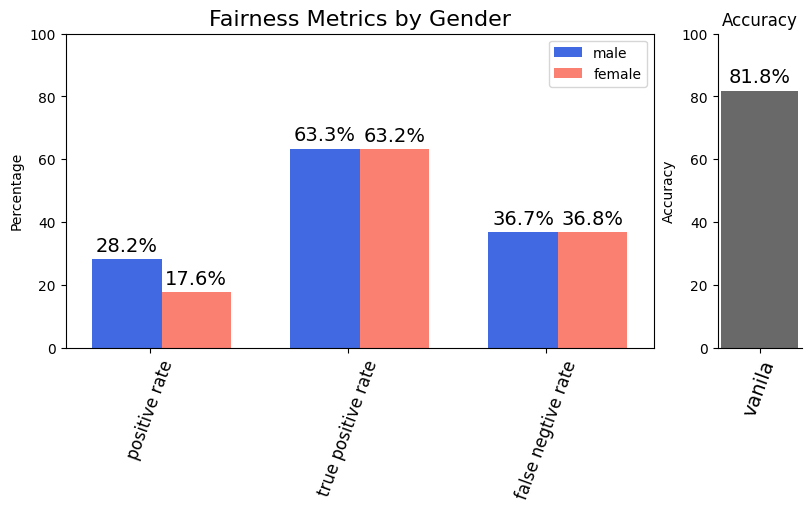

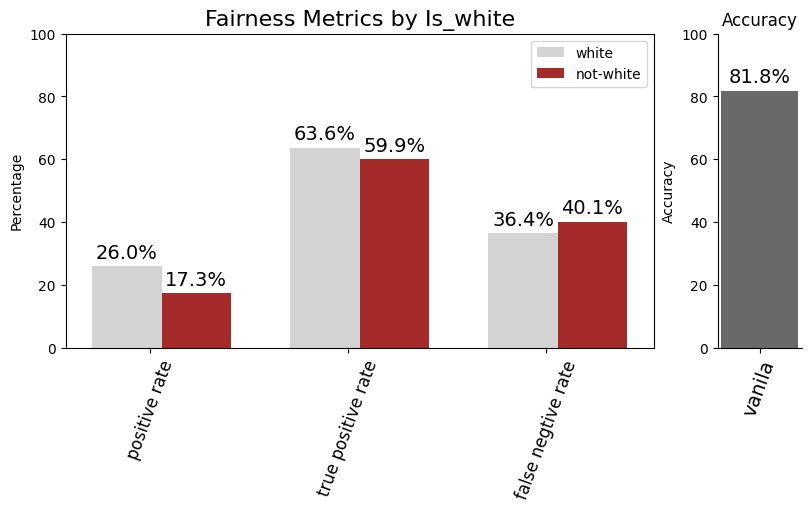

In [21]:
plot_fairness_metrics(100*pred_fair_full_accuracy, "vanila", [male_fair_metrics, female_fair_metrics], "gender")
plot_fairness_metrics(100*pred_fair_full_accuracy, "vanila", [white_fair_metrics, not_white_fair_metrics], "is_white")